In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
from tqdm.notebook import tqdm

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Ori2_Geo1_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [4]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['h', 'phi', 'l_t']
[[-0.62199086  0.52436829  0.9870429 ]
 [ 0.96410846 -0.56190141  0.97290612]
 [-0.96289368  0.92451588  0.2840063 ]
 ...
 [-0.06431852  0.78552483  0.62749283]
 [-0.1437634   0.48890781  0.49313733]
 [-0.12099594  0.5503719   0.59639753]]


In [5]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [7]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:22,  1.08s/it]

Training Loss: 104.62732470966876 Validation Loss: 28.128921166062355


  4%|▎         | 11/300 [00:11<05:11,  1.08s/it]

Training Loss: 57.477425104007125 Validation Loss: 17.164122181013227


  7%|▋         | 21/300 [00:22<05:01,  1.08s/it]

Training Loss: 51.106169493403286 Validation Loss: 16.22425980004482


 10%|█         | 31/300 [00:33<04:46,  1.06s/it]

Training Loss: 49.89556549675763 Validation Loss: 15.237790612271056


 14%|█▎        | 41/300 [00:44<04:37,  1.07s/it]

Training Loss: 23.38867826666683 Validation Loss: 8.956914077047259


 17%|█▋        | 51/300 [00:53<03:57,  1.05it/s]

Training Loss: 15.236144537222572 Validation Loss: 7.640734571032226


 20%|██        | 61/300 [01:03<04:05,  1.03s/it]

Training Loss: 11.486537636839785 Validation Loss: 6.712506651179865


 24%|██▎       | 71/300 [01:14<03:57,  1.04s/it]

Training Loss: 14.859285397687927 Validation Loss: 6.5169040989130735


 27%|██▋       | 81/300 [01:24<03:33,  1.03it/s]

Training Loss: 9.820626024040394 Validation Loss: 5.961938603664748


 30%|███       | 91/300 [01:34<03:32,  1.02s/it]

Training Loss: 9.99426920840051 Validation Loss: 5.898972232360393


 34%|███▎      | 101/300 [01:44<03:24,  1.03s/it]

Training Loss: 6.694120650005061 Validation Loss: 5.573373288614675


 37%|███▋      | 111/300 [01:55<03:13,  1.02s/it]

Training Loss: 5.236420969711617 Validation Loss: 5.727886458975263


 40%|████      | 121/300 [02:05<02:59,  1.00s/it]

Training Loss: 4.5605306418729015 Validation Loss: 5.939799041603692


 44%|████▎     | 131/300 [02:15<02:51,  1.02s/it]

Training Loss: 4.438884776784107 Validation Loss: 5.88236544164829


 47%|████▋     | 141/300 [02:25<02:41,  1.01s/it]

Training Loss: 4.387707500893157 Validation Loss: 5.793273344635963


 50%|█████     | 151/300 [02:35<02:32,  1.02s/it]

Training Loss: 2.5413144853009726 Validation Loss: 5.811145982326707


 54%|█████▎    | 161/300 [02:46<02:21,  1.02s/it]

Training Loss: 2.1943900718470104 Validation Loss: 5.580292809056118


 57%|█████▋    | 171/300 [02:56<02:12,  1.03s/it]

Training Loss: 2.521289801079547 Validation Loss: 5.968653333839029


 60%|██████    | 181/300 [03:06<02:00,  1.02s/it]

Training Loss: 1.6430882713684696 Validation Loss: 6.008242674754001


 64%|██████▎   | 191/300 [03:16<01:49,  1.01s/it]

Training Loss: 1.2539892649729154 Validation Loss: 5.949619035935029


 67%|██████▋   | 201/300 [03:26<01:38,  1.01it/s]

Training Loss: 1.0411757713882253 Validation Loss: 6.127594964811578


 70%|███████   | 211/300 [03:36<01:29,  1.01s/it]

Training Loss: 1.127395412971964 Validation Loss: 6.2033429075963795


 74%|███████▎  | 221/300 [03:46<01:20,  1.02s/it]

Training Loss: 0.7869018706624047 Validation Loss: 6.132864675251767


 77%|███████▋  | 231/300 [03:56<01:07,  1.03it/s]

Training Loss: 0.7418474538171722 Validation Loss: 6.132844118634239


 80%|████████  | 241/300 [04:06<01:00,  1.02s/it]

Training Loss: 0.6510937543207547 Validation Loss: 6.246340751647949


 84%|████████▎ | 251/300 [04:16<00:50,  1.02s/it]

Training Loss: 0.6239948738202656 Validation Loss: 6.273463794612326


 87%|████████▋ | 261/300 [04:27<00:40,  1.03s/it]

Training Loss: 0.5479835950018241 Validation Loss: 6.39323002344463


 90%|█████████ | 271/300 [04:37<00:29,  1.02s/it]

Training Loss: 0.5226826493744738 Validation Loss: 6.311742053134367


 94%|█████████▎| 281/300 [04:47<00:19,  1.03s/it]

Training Loss: 0.48783637283122516 Validation Loss: 6.336621917085722


 97%|█████████▋| 291/300 [04:57<00:09,  1.02s/it]

Training Loss: 0.46778032103247824 Validation Loss: 6.156797114759684


100%|██████████| 300/300 [05:06<00:00,  1.02s/it]


In [8]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.8504270567900796
(128, 3)
(128, 3)


<IPython.core.display.Javascript object>


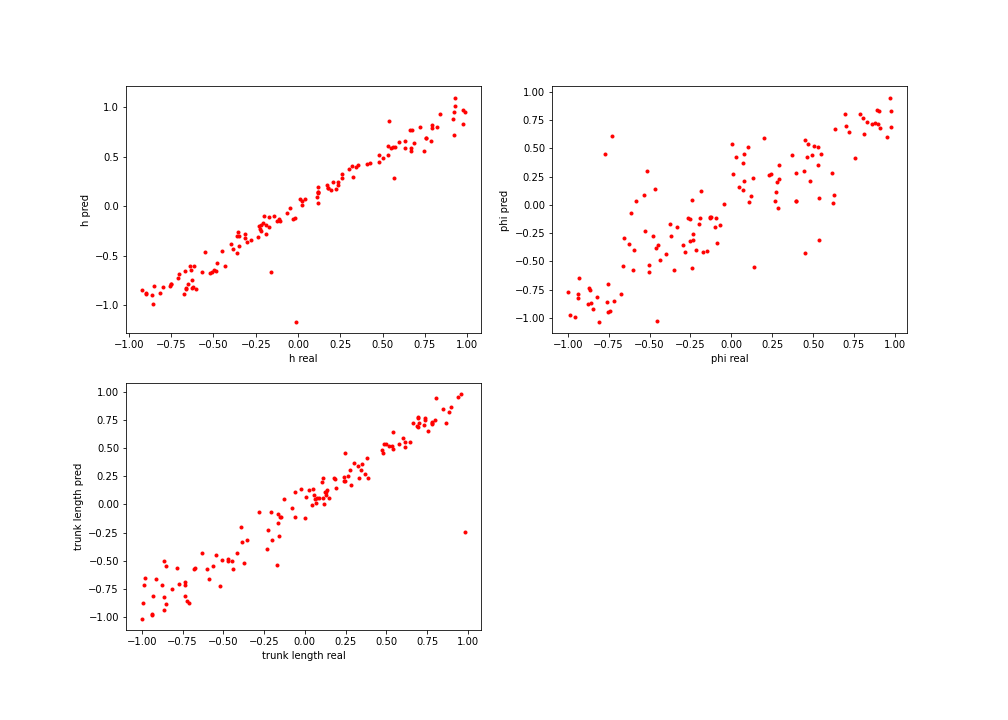

In [10]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))

# ax_d = plt.subplot(221)
# ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
# ax_d.set_xlabel('d real')
# ax_d.set_ylabel('d pred')

# ax_t = plt.subplot(222)
# ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
# ax_t.set_xlabel('theta real')
# ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(221)
ax_h.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(222)
ax_p.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(223)
ax_lt.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')


plt.show()

In [ ]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()